# Graph Convolutional Network

For this project, we utilize the **GCN (Graph Convolutional Network)** architecture proposed by *Kipf & Welling (2017)*. Unlike traditional Multilayer Perceptrons (MLPs) that treat data points in isolation, GCNs leverage the **graph structure (connections)** to learn node representations.

### How Information Aggregation Works
The core mechanism of a GCN is **Message Passing**. This process occurs in three main steps:

1.  **Aggregation:** Each node "collects" feature vectors from its immediate neighbors.
2.  **Normalization:** The aggregated information is normalized by the node degrees (to prevent high-degree nodes from dominating the signal).
3.  **Transformation:** The result is multiplied by a learnable weight matrix ($W$) and passed through a non-linear activation function (ReLU).

### Motivation for `ogbn-arxiv`
The `ogbn-arxiv` dataset represents a citation network. These networks exhibit strong **homophily**: papers tend to cite other papers within the same subject area.

> A GCN is ideal here because when the model is uncertain about a paper's content (text features), it can look at the "neighborhood" (citations) to refine the classification.

## 1. Model Implementation
We implement the model using **PyTorch Geometric (PyG)**. The network consists of **3 GCN layers**, allowing the model to aggregate information from up to 3 hops away in the graph.

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCN, self).__init__()
        
        # List of GCN layers and Batch Normalization layers
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        
        # First layer: Input features -> Hidden dimension
        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
        
        # Intermediate layers (if num_layers > 2)
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
            
        # Last layer: Hidden dimension -> Output (Number of Classes)
        self.convs.append(GCNConv(hidden_dim, output_dim))
        
        self.dropout = dropout

    def forward(self, x, adj_t):
        # x: Node feature matrix [num_nodes, num_features]
        # adj_t: Sparse adjacency matrix
        
        # Iterate through all layers except the last one
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)      # 1. Aggregation & Linear Transformation
            x = self.bns[i](x)      # 2. Batch Normalization
            x = F.relu(x)           # 3. Activation
            x = F.dropout(x, p=self.dropout, training=self.training) # 4. Regularization
            
        # Final layer (No activation here, we use LogSoftmax later)
        x = self.convs[-1](x, adj_t)
        
        return F.log_softmax(x, dim=1)

## 2. Hyperparameter Definition

We define a robust configuration based on OGB benchmarks.

  * **Hidden Dim (256):** Sufficient capacity to capture complex text features.
  * **Layers (3):** Balances local neighborhood aggregation without suffering from over-smoothing.
  * **Dropout (0.5):** High regularization is necessary to prevent overfitting on older papers (train set).


In [2]:
# Hyperparameter Configuration
args = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers': 3,
    'hidden_dim': 1024,
    'dropout': 0.5,
    'lr': 0.01,        # Learning rate for Adam
    'epochs': 500,     # Max epochs
    'input_dim': 128,  # Fixed by dataset (node_features.shape[1])
    'output_dim': 40   # Fixed by dataset (40 subject areas)
}

print(f"Configuration: {args}")
print(f"Running on: {args['device']}")

Configuration: {'device': 'cuda', 'num_layers': 3, 'hidden_dim': 1024, 'dropout': 0.5, 'lr': 0.01, 'epochs': 500, 'input_dim': 128, 'output_dim': 40}
Running on: cuda


## 3. Data Preprocessing

Before training, we must convert the OGB data into PyTorch tensors and apply graph transformations:

1.  **ToUndirected:** Citations are directed, but treating them as undirected often improves information flow (knowing who cites you is as important as knowing who you cite).
2.  **ToSparseTensor:** Optimizes memory usage and computation speed for GCNs.

In [3]:
from ogb.nodeproppred import NodePropPredDataset
data_dir = '../dataset' # Relative path from the project root

dataset = NodePropPredDataset(name='ogbn-arxiv', root=data_dir)

graph, labels = dataset[0]

c:\Users\Tulio\AppData\Local\Programs\Python\Python311\Lib\site-packages\outdated\__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
c:\Users\Tulio\AppData\Local\Programs\Python\Python311\Lib\site-packages\ogb\nodeproppred\dataset.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary obje

In [4]:
import torch_geometric.transforms as T
from torch_geometric.data import Data

# 1. Convert numpy arrays to PyTorch Tensors
x = torch.from_numpy(graph['node_feat']).to(torch.float)
y = torch.from_numpy(labels).to(torch.long).squeeze(1) # Flatten labels to [N]
edge_index = torch.from_numpy(graph['edge_index']).to(torch.long)

# 2. Create PyG Data object
data = Data(x=x, y=y, edge_index=edge_index)

# 3. Apply Transformations
# ToSparseTensor converts edge_index to a sparse matrix for faster GCN operations
transform = T.Compose([
    T.ToUndirected(),
    T.ToSparseTensor()
])

data = transform(data)
data = data.to(args['device'])

# Convert split indices from Numpy to Tensor before moving to device
split_idx = dataset.get_idx_split()
train_idx = torch.from_numpy(split_idx['train']).to(args['device'])
valid_idx = torch.from_numpy(split_idx['valid']).to(args['device'])
test_idx = torch.from_numpy(split_idx['test']).to(args['device'])

print("Data processed and moved to GPU/CPU.")

Data processed and moved to GPU/CPU.


c:\Users\Tulio\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\utils\sparse.py:276: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  adj = torch.sparse_csr_tensor(


## 4. Implementation & Training

### 4.1 Initialization

We initialize the model, the optimizer (Adam), and the official OGB evaluator.

In [5]:
from ogb.nodeproppred import Evaluator

# Initialize Model
model = GCN(input_dim=args['input_dim'], 
            hidden_dim=args['hidden_dim'], 
            output_dim=args['output_dim'], 
            num_layers=args['num_layers'], 
            dropout=args['dropout']).to(args['device'])

# OGB Evaluator (Calculates Accuracy)
evaluator = Evaluator(name='ogbn-arxiv')

# Optimizer and Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
criterion = torch.nn.NLLLoss() # Negative Log Likelihood

print("Model initialized:")
print(model)

Model initialized:
GCN(
  (convs): ModuleList(
    (0): GCNConv(128, 1024)
    (1): GCNConv(1024, 1024)
    (2): GCNConv(1024, 40)
  )
  (bns): ModuleList(
    (0-1): 2 x BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


### 4.2 Training and Evaluation Functions

  * **`train`**: Performs the forward pass, calculates loss on training nodes, and updates weights.
  * **`test`**: Evaluates the model on all splits (Train/Val/Test) without updating weights.

In [6]:
def train(model, data, train_idx, optimizer, criterion):
    model.train() # Enable Dropout

    optimizer.zero_grad() # Clear gradients
    
    # 1. Forward Pass (Full-Batch)
    out = model(data.x, data.adj_t)
    
    # 2. Calculate Loss ONLY on training nodes
    loss = criterion(out[train_idx], data.y[train_idx])
    
    # 3. Backward Pass
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def test(model, data, split_idx, evaluator):
    model.eval() # Disable Dropout

    # Predict for all nodes
    out = model(data.x, data.adj_t)
    
    # Get predicted class (argmax)
    y_pred = out.argmax(dim=-1, keepdim=True)

    # Calculate accuracy for each split
    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']].view(-1, 1),
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']].view(-1, 1),
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']].view(-1, 1),
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

### 4.3 Training Loop

We iterate through the epochs, tracking the loss and accuracy. We also implement a simple tracking mechanism to record the best validation performance (Early Stopping logic).

In [7]:
import time
import numpy as np

# --- Training Settings ---
args['epochs'] = 500  # High ceiling to let Early Stopping decide
patience = 50         # Early Stopping patience
patience_counter = 0 

print(f"--- Starting Training (No files will be saved) ---")
print(f"Max Epochs: {args['epochs']} | Patience: {patience}")

# Monitoring variables
best_valid_acc = 0
best_test_acc = 0
start_time = time.time()

# Dictionary to store history (for plotting later)
history = {
    'train_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'test_acc': []
}

# --- Training Loop ---
for epoch in range(1, args['epochs'] + 1):
    # 1. Train Step
    loss = train(model, data, train_idx, optimizer, criterion)
    
    # 2. Evaluation Step
    train_acc, valid_acc, test_acc = test(model, data, split_idx, evaluator)
    
    # 3. Update History
    history['train_loss'].append(loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)
    history['test_acc'].append(test_acc)
    
    # --- 4. Early Stopping Logic ---
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_test_acc = test_acc
        patience_counter = 0 # Reset counter (we improved!)
        # We don't save anything here, just update the in-memory record
    else:
        patience_counter += 1 # No improvement, increase counter
        
    # Check if we ran out of patience
    if patience_counter >= patience:
        print(f"\nEarly Stopping triggered at Epoch {epoch}!")
        print(f"Validation accuracy hasn't improved for {patience} epochs.")
        break 

    # Progress Log (Prints every 10 epochs or on the first one)
    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch: {epoch:03d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, '
              f'Val: {valid_acc:.4f}, '
              f'Test: {test_acc:.4f}, '
              f'Patience: {patience_counter}/{patience}')

end_time = time.time()
duration = end_time - start_time

# --- 5. Margin of Error Calculation & Final Results ---
num_test_samples = len(test_idx)
p = best_test_acc
margin_of_error = 1.96 * np.sqrt((p * (1 - p)) / num_test_samples)

print(f"\nTraining Finished in {duration:.2f} seconds.")
print(f"Stopped at Epoch: {epoch}")
print(f"Best Validation Accuracy: {best_valid_acc:.4f}")
print(f"Final Test Accuracy: {best_test_acc:.4f} ± {margin_of_error:.4f}")

--- Starting Training (No files will be saved) ---
Max Epochs: 500 | Patience: 50
Epoch: 001, Loss: 4.0544, Train: 0.2577, Val: 0.2902, Test: 0.2600, Patience: 0/50
Epoch: 010, Loss: 1.6522, Train: 0.2916, Val: 0.1941, Test: 0.1756, Patience: 9/50
Epoch: 020, Loss: 1.2926, Train: 0.3987, Val: 0.3181, Test: 0.3269, Patience: 8/50
Epoch: 030, Loss: 1.1627, Train: 0.5534, Val: 0.5203, Test: 0.5286, Patience: 0/50
Epoch: 040, Loss: 1.0862, Train: 0.6500, Val: 0.6226, Test: 0.6169, Patience: 2/50
Epoch: 050, Loss: 1.0352, Train: 0.6928, Val: 0.6827, Test: 0.6809, Patience: 0/50
Epoch: 060, Loss: 0.9968, Train: 0.7076, Val: 0.6962, Test: 0.6889, Patience: 1/50
Epoch: 070, Loss: 0.9681, Train: 0.7150, Val: 0.7011, Test: 0.6952, Patience: 5/50
Epoch: 080, Loss: 0.9397, Train: 0.7243, Val: 0.7129, Test: 0.7046, Patience: 1/50
Epoch: 090, Loss: 0.9191, Train: 0.7276, Val: 0.7127, Test: 0.7038, Patience: 4/50
Epoch: 100, Loss: 0.9010, Train: 0.7264, Val: 0.7069, Test: 0.7070, Patience: 5/50
Epoch

## 5. Results Analysis

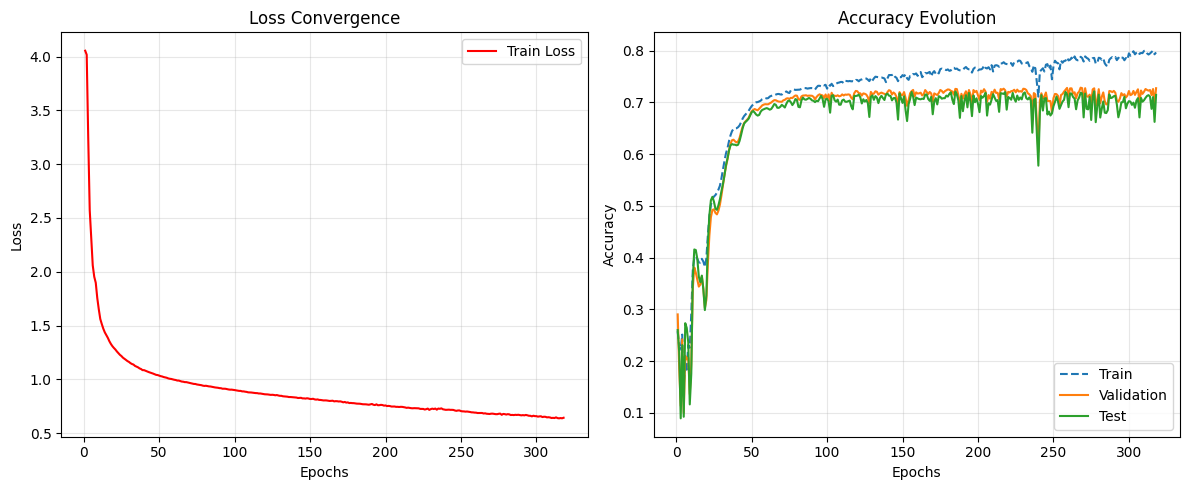

In [8]:
import matplotlib.pyplot as plt

loss = history['train_loss']
train_acc = history['train_acc']
val_acc = history['valid_acc']
test_acc = history['test_acc']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train', linestyle='--')
plt.plot(epochs, val_acc, label='Validation')
plt.plot(epochs, test_acc, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()